In [1]:
%matplotlib inline


DNN - Predict Face Orientation
=========================

In [2]:
import numpy as np
import os.path as osp
import sys

import cv2
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

Use combinations of Torchvision transforms to convert png cropped images into sets of tensors. The train set and the validation set are then compiled.

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = datasets.ImageFolder(root='./data_cropped/train', transform = train_transform)
validationdata = datasets.ImageFolder(root='./data_cropped/validation', transform = validation_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True)
validationloader = torch.utils.data.DataLoader(validationdata, batch_size = 4, shuffle = True)

classes = ('left', 'right')

The function imshow() performs the inverse function to the transform, unnormalising the tensor and then converting to a png to display the image.

 left  left  left right


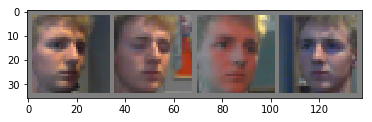

In [4]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Define the Convolutional Neural Network to take in 32x32x3 tensor and pass through two convolutional layers. Secondly define a Loss function and Optimiser.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

'''Define a Convolutional Neural Network'''

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

'''Define a Loss function and Optimiser'''

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train the DNN on the trainset, the data is iterated over three times and a count of the running loss is recorded as a method to measure performance.

In [6]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.921
[1,   400] loss: 0.317
[1,   600] loss: 0.169
[1,   800] loss: 0.188
[2,   200] loss: 0.116
[2,   400] loss: 0.095
[2,   600] loss: 0.095
[2,   800] loss: 0.101
[3,   200] loss: 0.089
[3,   400] loss: 0.073
[3,   600] loss: 0.042
[3,   800] loss: 0.066
Finished Training


Test the DNN on the validation set. First the known labels and displayed cropped images are shown and beneath are the predictions from the DNN.

GroundTruth:  right right right  left
Predicted:    right right right  left


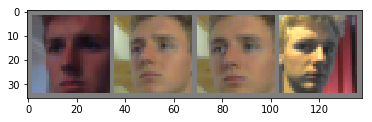

In [7]:
dataiter = iter(validationloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Assess the performance of the DNN by calculating the accuracy of the DNN across the whole validation set.

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 95 %
